# Anomaly Detection to flag suspicious login activity - MITRE ATT&CK Mapping
---

# Project Sections
---

- [Simulated Syslog for Base Input](#Simulated-Syslog-for-Base-Input)
- [Feature Engineering](#Feature-Engineering)
- [Isolation Forest Model for Anomaly Detection](#Isolation-Forest-Model-for-Anomaly-Detection)
- [Anomaly Visualization](#Anomaly-Visualization)
- [MITRE ATT&CK Mapping](#MITRE-ATT&CK-Mapping)

# Project Introduction
---

#### Built a Python-based anomaly detection model using Isolation Forest to flag suspicious login behavior such as unusual login hours, new geolocations, and failed attempts. 

* Simulated authentication logs to mimic enterprise scenarios, applied feature engineering.
* Used native macOS syslogs as base input to simulate real-world login activity,
* injected malicious patterns to test Isolation Forest–based anomaly detection.
* mapped findings to MITRE ATT&CK techniques T1110 and T1078.
* Visualized anomalies using Seaborn and Matplotlib. 
* Designed for use in security monitoring or SOC triage environments.

# Simulated Syslog for Base Input
---

Used native macOS syslogs as base input to simulate real-world login activity, injecting malicious patterns to test Isolation Forest–based anomaly detection; 
mapped findings to MITRE ATT&CK techniques T1110 and T1078.

In [1]:
import pandas as pd
data = pd.read_csv('/Users/johnryan/Downloads/Documents/Data Sets/dummy_syslog_login_events.csv')

In [2]:
data.describe()

,timestamp,user,ip,location,login_result
count,55,55,55,55,55
unique,52,3,47,5,2
top,2025-06-28 22:19:19,john,192.168.1.229,USA,success
freq,2,26,2,20,46


# Feature Engineering
---

## Business Logic for feature engineering and data conversion:

* Convert time stamp to Hour, day of the week, minute.
* user is a name field to be encoded.
* IP address is numeric & string convert to integer.
* Location is category to be encoded.
* login result set 1 = Fail 0 = Success.
* location is country name needs to be encoded.

__New fields__

* hour: derived from timestamp.
* minute: derived from timestamp.
* dayoftheweek: derived from timestamp.
* unusual_region_flag: list of unusual countries with logins.
* login_result_flag: User login 1 = yes, 2 = No


In [3]:
#check data types
data.dtypes

timestamp       object
user            object
ip              object
location        object
login_result    object
dtype: object

In [4]:
# convert data type from object to date time
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
#useful timestamp features for anomolies
data['hour'] = data['timestamp'].dt.hour
data['dayoftheweek'] = data['timestamp'].dt.dayofweek
data['minute'] = data['timestamp'].dt.minute


#Convert IP address to int
import ipaddress
data['ip_int'] = data['ip'].apply(lambda x: int(ipaddress.IPv4Address(x)))

                                  
#flag unusual regions outside of north america           
unusual_regions = ['China','Russia', 'UK']
data['unusual_region_flag'] = data['location'].map(lambda x: 1 if x in unusual_regions else 0)

                                  
#login result map fail = 1 else 0
data['login_result_flag'] = data['login_result'].str.lower().map({'fail': 1, 'success': 0})
                                  
#encode user + location categorical values to encode numeric representations
from sklearn.preprocessing import OrdinalEncoder
encoded_cat = ['user', 'location']
ordinal_encode = OrdinalEncoder()
data[encoded_cat] = ordinal_encode.fit_transform(data[encoded_cat])

data.head()

,timestamp,user,ip,location,login_result,hour,dayoftheweek,minute,ip_int,unusual_region_flag,login_result_flag
0,2025-06-28 18:59:19,2.0,192.168.1.229,3.0,success,18,5,59,3232236005,1,0
1,2025-06-28 19:09:19,2.0,192.168.1.224,3.0,success,19,5,9,3232236000,1,0
2,2025-06-28 19:19:19,0.0,192.168.1.212,3.0,success,19,5,19,3232235988,1,0
3,2025-06-28 19:29:19,2.0,192.168.1.254,0.0,success,19,5,29,3232236030,0,0
4,2025-06-28 19:39:19,0.0,192.168.1.72,4.0,success,19,5,39,3232235848,0,0


# Isolation Forest Model for Anomaly Detection
---

Train on normal events, let the Isolation Forest model flag anomalies based on the injected patterns. 

* Fits an IsolationForest model to the select preprocessed features.
* Flags rare or unusual events as anomalies.
* Adds a Boolean column is_anomaly_procedure to the DataFrame.

__Isolation Forest:__ An usupervised learning ensemble model Instead of profiling "normal" data, it isolates anomalies by randomly selecting a feature, then selecting a split value between its min and max. Since anomalies are rare and different, they get isolated faster.

contamination=0.01 tells the model that ~1% of the data is expected to be anomalous.

Isolation forset creates a new column __is_anomaly with True for anomalies, False otherwise__. Fits the model on features (a feature matrix of preprocessed encoded log data) and __labels points as anomalies (-1) or normal (1).__

In [11]:
from sklearn.ensemble import IsolationForest
features = data[['user', 'location', 'hour', 'dayoftheweek', 'minute', 'ip_int', 'unusual_region_flag', 'login_result_flag']]
clf = IsolationForest(contamination=0.1)
clf.fit(features)
data['anomaly_score'] = clf.decision_function(features)
data['is_anomaly'] = clf.predict(features) #-1 is anomoly 
data['anomaly_status'] = data['is_anomaly'].map({-1: 'anomaly', 1: 'normal'})
print(data['is_anomoly'].value_counts())


is_anomoly
 1    49
-1     6
Name: count, dtype: int64


The anomoly status column shows how many login attemps were not normal logins, 6 login attemps have very low anomoly scores which siganl unusual actitivy.

In [12]:
anomolies = data[data['anomaly_status'] == 'anomaly']
anomolies.head()

,timestamp,user,ip,location,login_result,hour,dayoftheweek,minute,ip_int,unusual_region_flag,login_result_flag,anomoly_score,is_anomoly,anomaly_status,anomaly_score,is_anomaly
20,2025-06-28 22:19:19,0.0,192.168.1.81,4.0,fail,22,5,19,3232235857,0,1,0.018138,1,anomaly,-0.001551,-1
41,2025-06-29 01:49:19,1.0,192.168.1.205,0.0,fail,1,6,49,3232235981,0,1,-0.030943,-1,anomaly,-0.034135,-1
50,2025-06-28 21:59:19,2.0,172.32.4.73,2.0,fail,21,5,59,2887779401,1,1,-0.073101,-1,anomaly,-0.078554,-1
51,2025-06-28 22:04:19,2.0,172.32.4.178,1.0,success,22,5,4,2887779506,1,0,-0.020948,-1,anomaly,-0.007809,-1
52,2025-06-28 22:09:19,2.0,172.32.4.45,1.0,fail,22,5,9,2887779373,1,1,-0.002309,-1,anomaly,-0.007194,-1


# Anomaly Visualization
---

### Anomaly Score Distribution

The following plot visualizes the distribution of anomaly scores produced by an anomaly detection model.
* This is a A smoothed estimate of the score distribution, helping to identify peaks and tails more clearly.
* the lower the anomaly score the more anomolous the data.
* Indicates whether anomalies are rare (left tail) or if there’s a broader spread of uncertain data points.

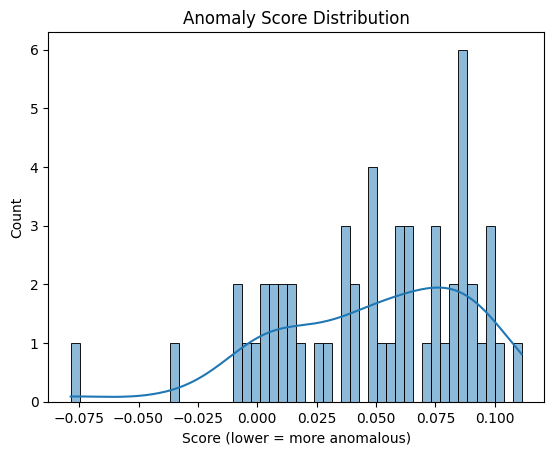

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['anomaly_score'], bins=50, kde=True)
plt.title('Anomaly Score Distribution')
plt.xlabel('Score (lower = more anomalous)')
plt.show()

### Smoothed Login Outcomes Over Time

This plot shows a time-series comparison of successful and failed login attempts, smoothed using a rolling average to highlight trends.
* Detects unusual spikes in failed logins, which may indicate brute-force attacks or credential stuffing attempts.
* Indicates trends in login behavior over time frame.
* Smoothing reduces noise, making patterns more visible.
* A sharp rise in the red line may signal unusual activity or system issues.

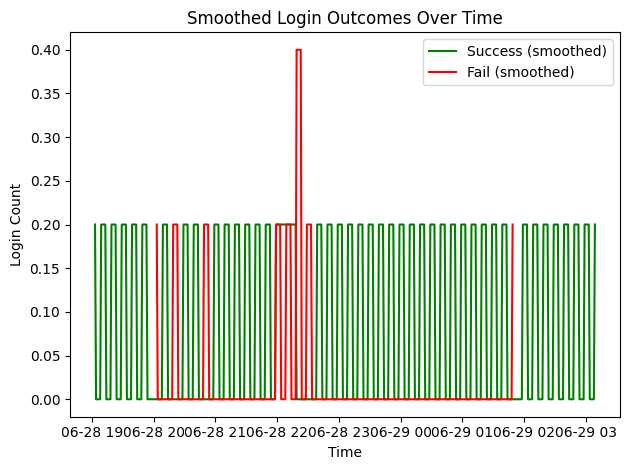

In [14]:
success = data[data['login_result_flag'] == 0]
fail = data[data['login_result_flag'] == 1]

success_counts = success.set_index('timestamp').resample('1T').size()
fail_counts = fail.set_index('timestamp').resample('1T').size()

window = 5  # 5-minute rolling window
success_rolling = success_counts.rolling(window).mean()
fail_rolling = fail_counts.rolling(window).mean()

plt.plot(success_rolling.index, success_rolling, label='Success (smoothed)', color='green')
plt.plot(fail_rolling.index, fail_rolling, label='Fail (smoothed)', color='red')
plt.title('Smoothed Login Outcomes Over Time')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.legend()
plt.tight_layout()
plt.show()

### IP Distribution by Login Result (Success vs Fail)

This visualization compares the distribution of IP addresses (represented as integers) between successful and failed login attempts.

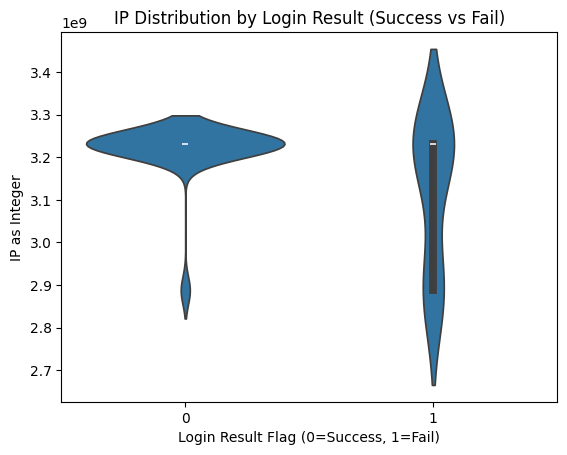

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x='login_result_flag', y='ip_int', data=data)
plt.title('IP Distribution by Login Result (Success vs Fail)')
plt.xlabel('Login Result Flag (0=Success, 1=Fail)')
plt.ylabel('IP as Integer')
plt.show()

# MITRE ATT&CK Mapping
---

### T1078 - Valid Accounts
---
T1078 – Valid Accounts maps to successful logins from unusual sources even though the anomoly status is 'normal'
* Can indicate quiet access with real usernames and passwords.
* This can help identify if access was from wrong country, odd time or new device.

In [38]:
#creates a filter for unusual location logins even though the anomoly status is 'normal'
valid_logins = data[(data['login_result_flag']==0) | (data['unusual_region_flag']==1) | (data['anomaly_status']=='normal')].copy()

#add column in dataframe with a new string for valid accounts
valid_logins['MITRE_mapping'] = 'T1078-Valid Accounts'
valid_logins.head()

,timestamp,user,ip,location,login_result,hour,dayoftheweek,minute,ip_int,unusual_region_flag,login_result_flag,anomoly_score,is_anomoly,anomaly_status,anomaly_score,is_anomaly,MITRE_mapping
0,2025-06-28 18:59:19,2.0,192.168.1.229,3.0,success,18,5,59,3232236005,1,0,0.076602,1,normal,0.060903,1,T1078-Valid Accounts
1,2025-06-28 19:09:19,2.0,192.168.1.224,3.0,success,19,5,9,3232236000,1,0,0.098777,1,normal,0.087007,1,T1078-Valid Accounts
2,2025-06-28 19:19:19,0.0,192.168.1.212,3.0,success,19,5,19,3232235988,1,0,0.060546,1,normal,0.050389,1,T1078-Valid Accounts
3,2025-06-28 19:29:19,2.0,192.168.1.254,0.0,success,19,5,29,3232236030,0,0,0.078751,1,normal,0.074313,1,T1078-Valid Accounts
4,2025-06-28 19:39:19,0.0,192.168.1.72,4.0,success,19,5,39,3232235848,0,0,0.083498,1,normal,0.091294,1,T1078-Valid Accounts
